# Implementing an Autoencoder in PyTorch

## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Set the batch size.

In [3]:
batch_size = 64

Create device for tensors (use CUDA, if available).

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Dataset

We load our MNIST dataset using the `torchvision` package. 

In [5]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.MNIST(
    root="./torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="./torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

## Autoencoder

In [6]:
encoded_space_dim = 12

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(1, 2, 3, stride=2, padding=1), # 28x28 -> 14x14
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(2),
            nn.Dropout(0.05),

            nn.Conv2d(2, 4, 3, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout(0.05),
            
            nn.Flatten(start_dim=1),
            
            nn.Linear(4 * 7 * 7, 4 * encoded_space_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(0.05),

            nn.Linear(4 * encoded_space_dim, encoded_space_dim),
            #torch.nn.Sigmoid(),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoded_space_dim, 4 * encoded_space_dim),
            nn.ReLU(inplace=True),
            
            torch.nn.Linear(4 * encoded_space_dim, 4 * 7 * 7),
            nn.ReLU(inplace=True),

            nn.Unflatten(dim=1, unflattened_size=(4, 7, 7)),

            nn.ConvTranspose2d(4, 2, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(2, 1, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(x)


class AE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


encoder = Encoder()
decoder = Decoder()
model = AE(encoder=encoder, decoder=decoder).to(device)

In [7]:
def fit(epochs, lr):
    # create an optimizer object
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # mean-squared error loss
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        loss = 0
        for batch_features, _ in train_loader:
            batch_features = batch_features.view(-1, 1, 28, 28).to(device)

            # compute reconstructions
            outputs = model(batch_features)
            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_features)

            # reset the gradients back to zero
            optimizer.zero_grad()
            # compute accumulated gradients
            train_loss.backward()
            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(train_loader)

        # display the epoch training loss
        print("lr: {}, epoch: {:>{}}/{}, recon loss = {:.8f}".format(lr, epoch + 1, len(str(epochs)), epochs, loss))

fit(epochs=3, lr=1e-1)
fit(epochs=10, lr=5e-2)
fit(epochs=10, lr=1e-2)
fit(epochs=10, lr=5e-3)
fit(epochs=10, lr=1e-3)
fit(epochs=10, lr=5e-4)

lr: 0.1, epoch: 1/3, recon loss = 0.05091223
lr: 0.1, epoch: 2/3, recon loss = 0.03950349
lr: 0.1, epoch: 3/3, recon loss = 0.03869610
lr: 0.05, epoch:  1/10, recon loss = 0.03574624
lr: 0.05, epoch:  2/10, recon loss = 0.03544740
lr: 0.05, epoch:  3/10, recon loss = 0.03546960
lr: 0.05, epoch:  4/10, recon loss = 0.03535154
lr: 0.05, epoch:  5/10, recon loss = 0.03535816
lr: 0.05, epoch:  6/10, recon loss = 0.03537322
lr: 0.05, epoch:  7/10, recon loss = 0.03528343
lr: 0.05, epoch:  8/10, recon loss = 0.03535421
lr: 0.05, epoch:  9/10, recon loss = 0.03530898
lr: 0.05, epoch: 10/10, recon loss = 0.03525838
lr: 0.01, epoch:  1/10, recon loss = 0.03169093
lr: 0.01, epoch:  2/10, recon loss = 0.03057379
lr: 0.01, epoch:  3/10, recon loss = 0.02943239
lr: 0.01, epoch:  4/10, recon loss = 0.02856725
lr: 0.01, epoch:  5/10, recon loss = 0.02786250
lr: 0.01, epoch:  6/10, recon loss = 0.02755011
lr: 0.01, epoch:  7/10, recon loss = 0.02741039
lr: 0.01, epoch:  8/10, recon loss = 0.02735723
l

In [8]:
#fit(epochs=10, lr=1e-3)

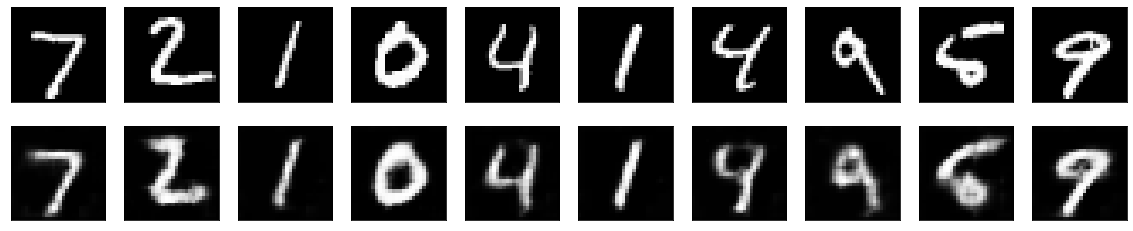

tensor([[0.0000, 0.9890, 0.7826, 0.8860, 1.3628, 0.8759, 0.5458, 0.0000, 1.9108,
         0.2434, 0.9751, 2.2375]])


In [9]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=False
)

with torch.no_grad():
    for batch_features in test_loader:
        test_examples = batch_features[0].view(-1, 1, 28, 28)
        reconstruction = model(test_examples)
        break

with torch.no_grad():
    plt.figure(figsize=(20, 4))
    for index in range(len(test_examples)):
        # display original
        ax = plt.subplot(2, len(test_examples), index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, len(test_examples), index + 1 + len(test_examples))
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

with torch.no_grad():
    print(encoder(test_examples[0].reshape(1,1,28,28)))

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])


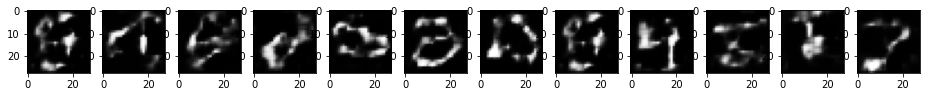

In [10]:
plt.figure(figsize=(16, 4))
with torch.no_grad():
    for i in range(encoded_space_dim):
        ax = plt.subplot(1, encoded_space_dim, i + 1)
        encoded = torch.tensor([[int(j == i) for j in range(encoded_space_dim)]], dtype=torch.float32)
        print(encoded)
        decoded = decoder(encoded)
        plt.imshow(decoded.numpy().reshape(28, 28))
plt.show()

We can generate an image from our own vector.

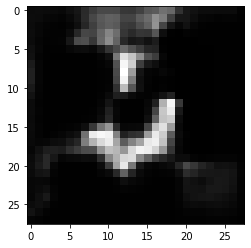

In [11]:
with torch.no_grad():
    encoded = torch.tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], dtype=torch.float32)
    decoded = decoder(encoded)
    plt.imshow(decoded.numpy().reshape(28, 28))
    plt.show()

Let's generate some random images.

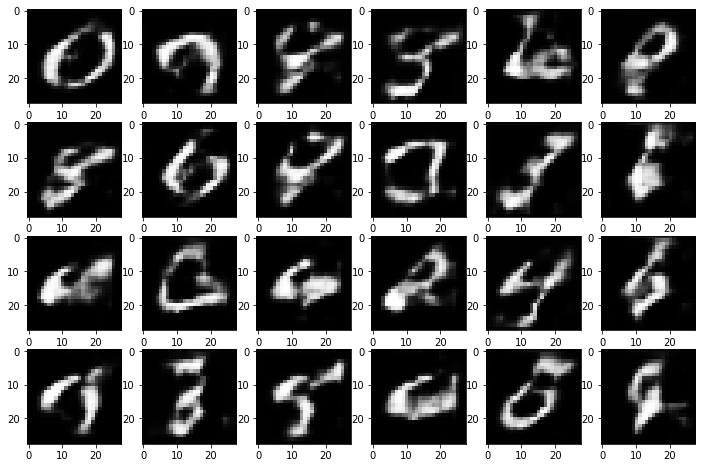

In [12]:
rows = 4
cols = 6
plt.figure(figsize=(cols * 2, rows * 2))
with torch.no_grad():
    for i in range(rows * cols):
        ax = plt.subplot(rows, cols, i + 1)
        encoded = torch.rand([1, encoded_space_dim], dtype=torch.float32)
        decoded = decoder(encoded)
        #print(encoded)
        plt.imshow(decoded.numpy().reshape(28, 28))
plt.show()